## Использование алгоритма CatBoost для выявления факторов, ведущих к увольнению сотрудника ##

Исследование датасета

Установка пакета Yandex CatBoost

In [ ]:
!pip install catboost

Импорт необходимых пакетов: Numpy, Pandas, Matplotlib, Seaborn, Scikit-learn и CatBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

Загружаем датасет. Это вымышленный набор данных, созданный специалистами по данным IBM. https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [ ]:
ibm_hr_df = pd.read_csv("/content/sample_data/IBM-HR-Employee-Attrition.csv")
ibm_hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Просмотр типов данных. Это данные типа object, int.

In [ ]:
ibm_hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

### Часть 1a: Исследование данных - сводная статистика ###

Получение сводной статистики набора данных IBM HR

In [ ]:
ibm_hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


Выявление нерелевантных атрибутов __*EmployeeCount*__ и __*StandardHours*__

In [ ]:
irrList = ['EmployeeCount', 'StandardHours'] 
ibm_hr_df[irrList].describe()

,EmployeeCount,StandardHours
count,1470.0,1470.0
mean,1.0,80.0
std,0.0,0.0
min,1.0,80.0
25%,1.0,80.0
50%,1.0,80.0
75%,1.0,80.0
max,1.0,80.0


Выявление нерелевантного атрибута __*Over18*__ 

In [ ]:
ibm_hr_df["Over18"].value_counts()

Y    1470
Name: Over18, dtype: int64

Из сводной статистики видно, что атрибуты __*EmployeeCount*__, __*StandardHours*__ и __*Over18*__ содержат только одно значение для всех 1470 записей <br>

__*EmployeeCount*__ содержит только одно значение - 1.0 <br>
__*StandardHours*__ содержит только одно значение - 80.0 <br>
__*Over18*__        содержит только одно значение - 'Y'  <br>

Эти нерелевантные атрибуты удалим из набора данных

### Часть 1b: Исследование данных - отсутствующие значения и повторяющиеся записи ###

Проверка на неопределённые и отсутствующие значения.

In [ ]:
ibm_hr_df.isnull().sum(axis=0)

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

Что ж, нам здесь повезло, в этом наборе данных нет пропущенных значений

Далее проверим наличие повторяющихся записей в наборе данных.

In [ ]:
ibm_hr_df.duplicated().sum()

0

В наборе данных также нет повторяющихся записей.

Преобразование двоичного категориального атрибута __*OverTime*__ в {1, 0}

In [ ]:
ibm_hr_df['OverTime'].replace(to_replace=dict(Yes=1, No=0), inplace=True)

### Часть 2a: Предварительная обработка данных - удаление нерелевантных атрибутов ###

In [ ]:
ibm_hr_df = ibm_hr_df.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

### Часть 2b: Предварительная Обработка Данных - Выбор Подмножества Признаков - Low Variance Filter  ###

Выполнение дисперсионного анализа

Выполнение корреляционного анализа Пирсона между атрибутами для облегчения уменьшения размерности

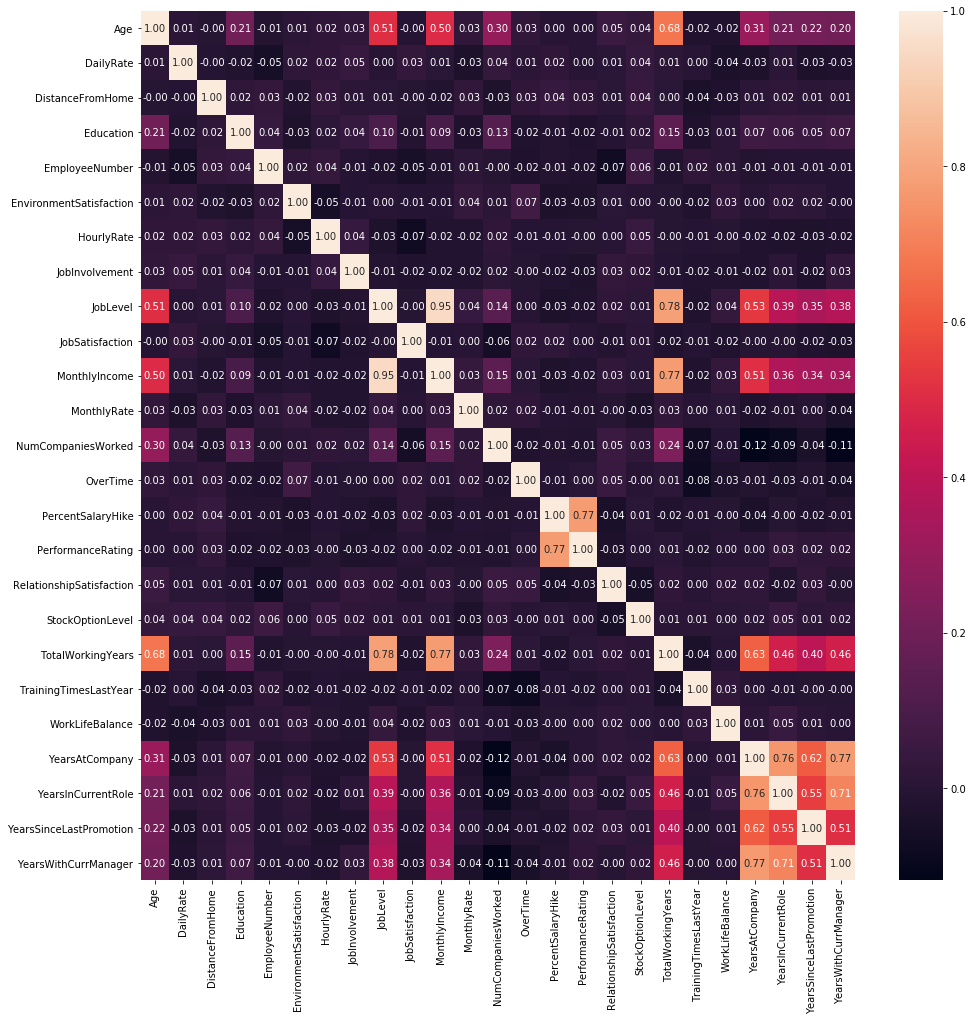

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(ibm_hr_df.corr(), annot=True, fmt=".2f")

plt.show()

Выполнение дисперсионного анализа для облегчения уменьшения размеров

In [ ]:
variance_x = ibm_hr_df.drop('Attrition', axis=1)
variance_one_hot = pd.get_dummies(variance_x)

In [ ]:
#Нормализовать набор данных. Это необходимо для получения порога дисперсии.
scaler = MinMaxScaler()
scaler.fit(variance_one_hot)
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_variance_one_hot = scaler.transform(variance_one_hot)

In [ ]:
#Установить пороговые значения и запустить VarianceThreshold 
thres = .85* (1 - .85)
sel = VarianceThreshold(threshold=thres)
sel.fit(scaled_variance_one_hot)
variance = sel.variances_

In [ ]:
#Сортировка в порядке возрастания для построения графика
indices = np.argsort(variance)[::-1]
feature_list = list(variance_one_hot)
sorted_feature_list = []
thres_list = []
for f in range(len(variance_one_hot.columns)):
    sorted_feature_list.append(feature_list[indices[f]])
    thres_list.append(thres)

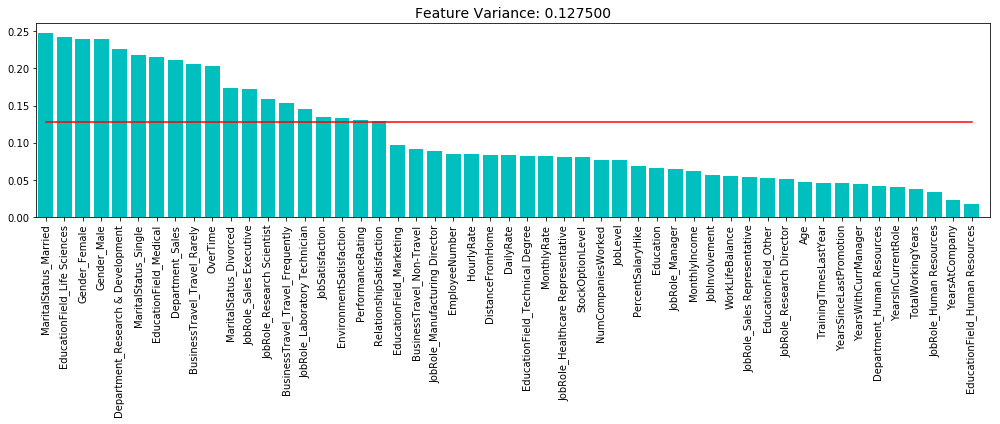

In [ ]:
plt.figure(figsize=(14,6))
plt.title("Feature Variance: %f" %(thres), fontsize = 14)
plt.bar(range(len(variance_one_hot.columns)), variance[indices], color="c")
plt.xticks(range(len(variance_one_hot.columns)), sorted_feature_list, rotation = 90)
plt.xlim([-0.5, len(variance_one_hot.columns)])
plt.plot(range(len(variance_one_hot.columns)), thres_list, "k-", color="r")
plt.tight_layout()
plt.show()

Выполнение корреляционного анализа Пирсона между атрибутами для облегчения уменьшения размерности

### Часть 3 ###

In [ ]:
rAttrList = ['Department', 'OverTime', 'HourlyRate',
             'StockOptionLevel', 'DistanceFromHome',
             'YearsInCurrentRole', 'Age']

In [ ]:
#храните только список атрибутов в rAttrList
label_hr_df = ibm_hr_df[rAttrList]

In [ ]:
#преобразование непрерывного атрибута DistanceFromHome в категориальный
#: 1: близко, 2: среднее растояние, 3: далеко
maxValues = label_hr_df['DistanceFromHome'].max()
minValues = label_hr_df['DistanceFromHome'].min()
intervals = (maxValues - minValues)/3
bins = [0, (minValues + intervals), (maxValues - intervals), maxValues]
groupName = [1, 2, 3]
label_hr_df['CatDistanceFromHome'] = pd.cut(label_hr_df['DistanceFromHome'], bins, labels = groupName)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# приведение типа к int64
label_hr_df['CatDistanceFromHome'] = pd.to_numeric(label_hr_df['CatDistanceFromHome']) 
label_hr_df.drop(['DistanceFromHome'], axis = 1, inplace = True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
#переместить названия подразделений в 0 & 1, 0: R&D, and 1: Non-R&D
label_hr_df['Department'].replace(['Research & Development', 'Human Resources', 'Sales'],
                                  [0, 1, 1], inplace = True)

In [ ]:
#нормализация данных
label_hr_df_norm = (label_hr_df - label_hr_df.min()) / (label_hr_df.max() - label_hr_df.min())

In [ ]:
#создать data frame для значения функций и меток классов
value_df = pd.DataFrame(columns = ['ClassValue'])

In [ ]:
#вычислить значение класса
for row in range (0, ibm_hr_df.shape[0]):
    if label_hr_df_norm['Department'][row] == 0:
        value = 0.3 * label_hr_df_norm['HourlyRate'][row] - 0.2 * label_hr_df_norm['OverTime'][row] + \
            - 0.2 * label_hr_df_norm['CatDistanceFromHome'][row] + 0.15 * label_hr_df_norm['StockOptionLevel'][row] + \
            0.1 * label_hr_df_norm['Age'][row] - 0.05 * label_hr_df_norm['YearsInCurrentRole'][row]
    
    else:
        value = 0.2 * label_hr_df_norm['HourlyRate'][row] - 0.3 * label_hr_df_norm['OverTime'][row] + \
            - 0.15 * label_hr_df_norm['CatDistanceFromHome'][row] + 0.2 * label_hr_df_norm['StockOptionLevel'][row] + \
            0.05 * label_hr_df_norm['Age'][row] - 0.1 * label_hr_df_norm['YearsInCurrentRole'][row]
    value_df.loc[row] = value

In [ ]:
# top 500 высшего класса довольны своей работой
v1 = value_df.sort_values('ClassValue', ascending = False).reset_index(drop = True)\
        ['ClassValue'][499]
# следующие top 500 нейтральны
v2 = value_df.sort_values('ClassValue', ascending = False).reset_index(drop = True)\
        ['ClassValue'][999]
# остальные неудовлетворены своей работой

In [ ]:
label_df = pd.DataFrame(columns = ['ClassLabel'])

In [ ]:
#вычислить classlabel
for row in range (0, value_df.shape[0]):
    if value_df['ClassValue'][row] >= v1:
        cat = "Satisfied"
    elif value_df['ClassValue'][row] >= v2:
        cat = "Neutral"
    else:
        cat = "Unsatisfied"
    label_df.loc[row] = cat

In [ ]:
df = pd.concat([ibm_hr_df, label_df], axis = 1)

### Часть 3: Классификация с помощью CatBoost ###

In [ ]:
df = df[['Age', 'Department', 'DistanceFromHome', 'HourlyRate', 'OverTime', 'StockOptionLevel', 
         'MaritalStatus', 'YearsInCurrentRole', 'EmployeeNumber', 'ClassLabel']]

Разбиение данных на attributes/features __*X*__ и label/class __*y*__

In [ ]:
X = df.drop('ClassLabel', axis=1)
y = df.ClassLabel

Замена label/class значений из __*'Satisfied'*__, __*'Neutral'*__ и *__'Unsatisfied'__* в *__2__*, __*1*__ and __*0*__

In [ ]:
y.replace(to_replace=dict(Satisfied=2, Neutral=1, Unsatisfied=0), inplace=True)

Выполнение __'one hot encoding'__ метода

In [ ]:
one_hot = pd.get_dummies(X)

Нормализация функции

In [ ]:
one_hot = (one_hot - one_hot.mean()) / (one_hot.max() - one_hot.min())

In [ ]:
categorical_features_indices = np.where(one_hot.dtypes != np.float)[0]

### Часть 3a: Обучение модели с помощью CatBoost ###
Теперь давайте разделим наши данные на обучающий (70%) и тестовый (30%) набор:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(one_hot, y, train_size=0.7, random_state=1234)

In [ ]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    random_seed = 100,
    loss_function = 'MultiClass'
)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = True,
    #plot = True
)

Learning rate set to 0.079242
0:	learn: 1.0312448	total: 3.53ms	remaining: 3.52s
1:	learn: 0.9667097	total: 6.14ms	remaining: 3.06s
2:	learn: 0.9189766	total: 8.72ms	remaining: 2.9s
3:	learn: 0.8786445	total: 11.2ms	remaining: 2.79s
4:	learn: 0.8369363	total: 13.8ms	remaining: 2.75s
5:	learn: 0.7954649	total: 16.3ms	remaining: 2.7s
6:	learn: 0.7634820	total: 18.8ms	remaining: 2.67s
7:	learn: 0.7342294	total: 21.8ms	remaining: 2.7s
8:	learn: 0.7094003	total: 24.4ms	remaining: 2.68s
9:	learn: 0.6845187	total: 27.3ms	remaining: 2.7s
10:	learn: 0.6590169	total: 30.4ms	remaining: 2.74s
11:	learn: 0.6395683	total: 33.2ms	remaining: 2.73s
12:	learn: 0.6134986	total: 37.4ms	remaining: 2.84s
13:	learn: 0.5950633	total: 41.5ms	remaining: 2.92s
14:	learn: 0.5775686	total: 44.4ms	remaining: 2.91s
15:	learn: 0.5585565	total: 47.3ms	remaining: 2.91s
16:	learn: 0.5442541	total: 50.1ms	remaining: 2.9s
17:	learn: 0.5280276	total: 54.1ms	remaining: 2.95s
18:	learn: 0.5136823	total: 57.1ms	remaining: 2.9

In [ ]:
feature_score = pd.DataFrame(list(zip(one_hot.dtypes.index, model.get_feature_importance(Pool(one_hot, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

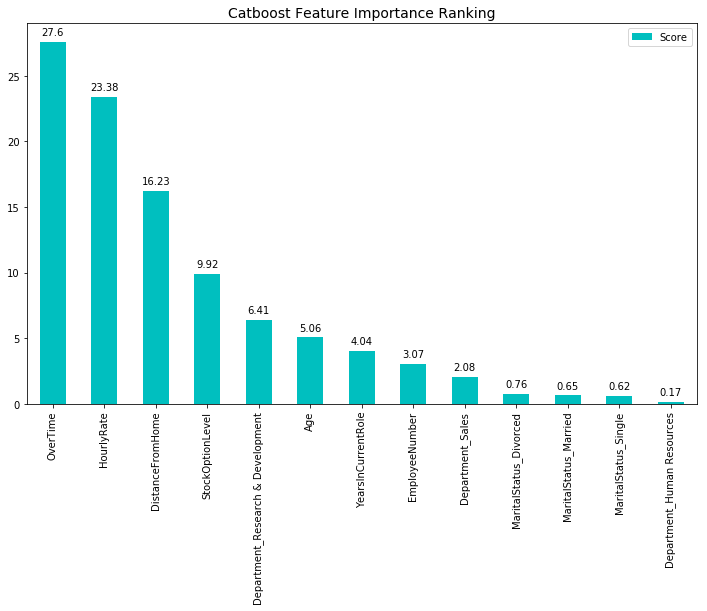

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
model.score(X_test, y_test)

0.9251700680272109

### Часть 4: CatBoost Настройка Классификатора ###

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg = 3,
    iterations = 1000,
    fold_len_multiplier = 1.05,
    learning_rate = 0.05,
    custom_loss = ['Accuracy'],
    random_seed = 100,
    loss_function = 'MultiClass'
)

In [ ]:
model.fit(
    X_train, y_train,
    cat_features = categorical_features_indices,
    verbose = True,
    #plot = True
)

0:	learn: 1.0555929	total: 2.82ms	remaining: 2.81s
1:	learn: 1.0125553	total: 5.68ms	remaining: 2.83s
2:	learn: 0.9792847	total: 8.16ms	remaining: 2.71s
3:	learn: 0.9478631	total: 10.6ms	remaining: 2.64s
4:	learn: 0.9167174	total: 13.4ms	remaining: 2.66s
5:	learn: 0.8869031	total: 15.8ms	remaining: 2.62s
6:	learn: 0.8612635	total: 18.4ms	remaining: 2.61s
7:	learn: 0.8370226	total: 20.8ms	remaining: 2.58s
8:	learn: 0.8151330	total: 23.6ms	remaining: 2.6s
9:	learn: 0.7945432	total: 26.2ms	remaining: 2.59s
10:	learn: 0.7725020	total: 28.8ms	remaining: 2.59s
11:	learn: 0.7548076	total: 31.5ms	remaining: 2.6s
12:	learn: 0.7319254	total: 34ms	remaining: 2.58s
13:	learn: 0.7147680	total: 36.5ms	remaining: 2.57s
14:	learn: 0.6950388	total: 42.5ms	remaining: 2.79s
15:	learn: 0.6761170	total: 45.3ms	remaining: 2.78s
16:	learn: 0.6626341	total: 47.8ms	remaining: 2.76s
17:	learn: 0.6462150	total: 50.4ms	remaining: 2.75s
18:	learn: 0.6311881	total: 52.8ms	remaining: 2.73s
19:	learn: 0.6163749	total

In [ ]:
feature_score = pd.DataFrame(list(zip(one_hot.dtypes.index, model.get_feature_importance(Pool(one_hot, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

In [ ]:
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

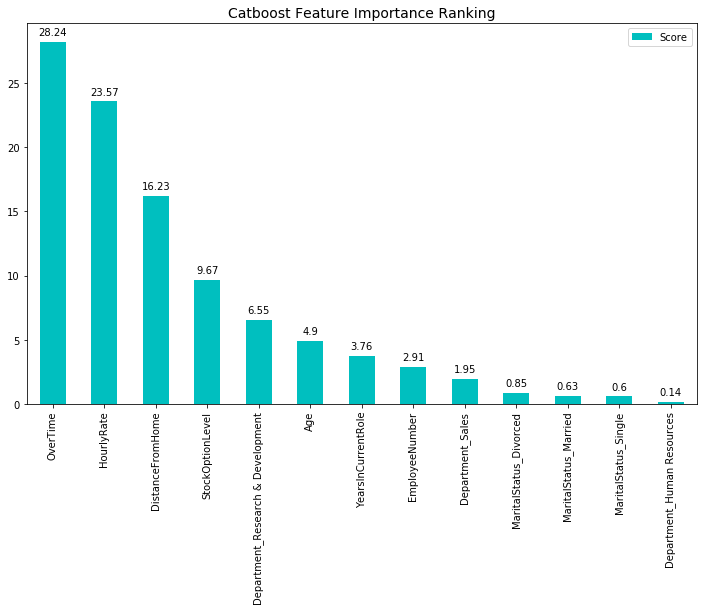

In [ ]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()
#plt.savefig("image.png")

Как видно по графику, что наибольшей важностью обладает признак __*OverTime*__.

In [ ]:
cm = pd.DataFrame()
cm['Satisfaction'] = y_test
cm['Predict'] = model.predict(X_test)

In [ ]:
mappingSatisfaction = {0:'Unsatisfied', 1: 'Neutral', 2: 'Satisfied'}
mappingPredict = {0.0:'Unsatisfied', 1.0: 'Neutral', 2.0: 'Satisfied'}
cm = cm.replace({'Satisfaction': mappingSatisfaction, 'Predict': mappingPredict})

In [ ]:
pd.crosstab(cm['Satisfaction'], cm['Predict'], margins=True)

Predict,Neutral,Satisfied,Unsatisfied,All
Satisfaction,,,,
Neutral,144,11,5,160
Satisfied,9,136,0,145
Unsatisfied,8,0,128,136
All,161,147,133,441


In [ ]:
model.score(X_test, y_test)

0.9251700680272109